## Zimbabwe GIS

* https://zimgeospatial.github.io/
* https://matthewrocklin.com/blog/work/2017/09/21/accelerating-geopandas-1
* https://zapcircle.net/geomapping-with-python/
* https://automating-gis-processes.github.io/2017/lessons/L5/share-on-github.html

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt

from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.tile_providers import get_provider, Vendors
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.layouts import row, column
from bokeh.models import CustomJS, Slider, Select
import tools

output_notebook()
#output_file('test.html')

Loading BokehJS ...

In [14]:
def plot_gdf(gdf, column, title='',cmap='Spectral', fillna=None, legend_kwds={}, 
             filename=None, towns=False, **kwargs):
    #gdf[column] = gdf[column]/gdf['pop']
    fig, ax = plt.subplots(1, figsize=(10,10))
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cax = inset_axes(ax,
                    width="5%", 
                    height="50%",                     
                    loc='lower left')
    if fillna!=None:
        gdf[column] = gdf[column].fillna(fillna)
    gdf.plot(column=column,edgecolor='0.1',lw=0.4,cmap=cmap, ax=ax,cax=cax,
            legend_kwds=legend_kwds, **kwargs)
    if towns == True:
        #prov.plot(ax=ax)
        #maintowns.plot(ax=ax)
        maintowns.apply(lambda x: ax.annotate(s=x.NAME, xy=x.geometry.centroid.coords[0], ha='left'),axis=1)
    ax.axis('off')
    ax.set_title(title, fontsize=20)
    plt.tight_layout()
    if filename != None:
        plt.savefig(filename,dpi=200) 

## towns of zimbabwe

In [9]:
towns=gpd.read_file('data/Final_Zimbabwe_Towns_Version01.shp')
names = ['Harare','Bulawayo','Mutare','Gweru','Masvingo','Kadoma','Nyanga','Rusape',
         'Marondera','Chinhoyi','Chivhu',
         'Kwekwe','Kariba','Victoria Falls','Triangle','Chimanimani','Hwange']
maintowns = towns[towns.NAME.isin(names)].drop_duplicates('NAME')

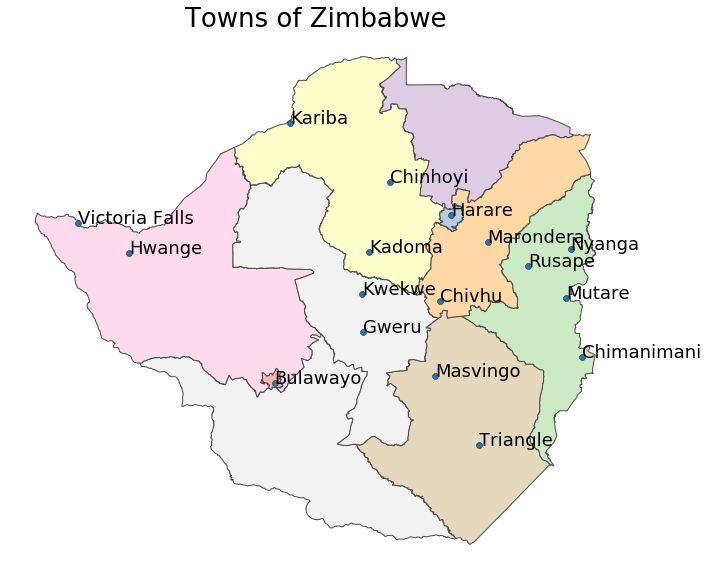

In [10]:
fig, ax = plt.subplots(1, figsize=(10,10))
prov.plot(ax=ax, column='province', edgecolor='0.3', cmap='Pastel1')
maintowns.plot(linewidth=.6, edgecolor='0.2', ax=ax)
maintowns.apply(lambda x: ax.annotate(s=x.NAME, xy=x.geometry.centroid.coords[0], ha='left',fontsize=18),axis=1)
ax.axis('off')
plt.title('Towns of Zimbabwe',fontsize=26)
plt.tight_layout()
plt.savefig('images/zim_towns.png',dpi=200)

In [6]:
def get_merged(shpfile,datafile,key):
    gdf = gpd.read_file(shpfile)
    data = pd.read_csv(datafile)
    gdf = gdf.merge(data,left_on=key,right_on=key,how='left')
    gdf.head()
    return gdf

prov = get_merged('data/admin_level1_provinces.shp','data/province_population.csv','province')
dist = get_merged('data/admin_level2_districts.shp','data/district_population.csv','district')
ward = get_merged('data/admin_level3_wards.shp','data/ward_population.csv' ,'district')
ward['ward'] = ward.wardname_x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


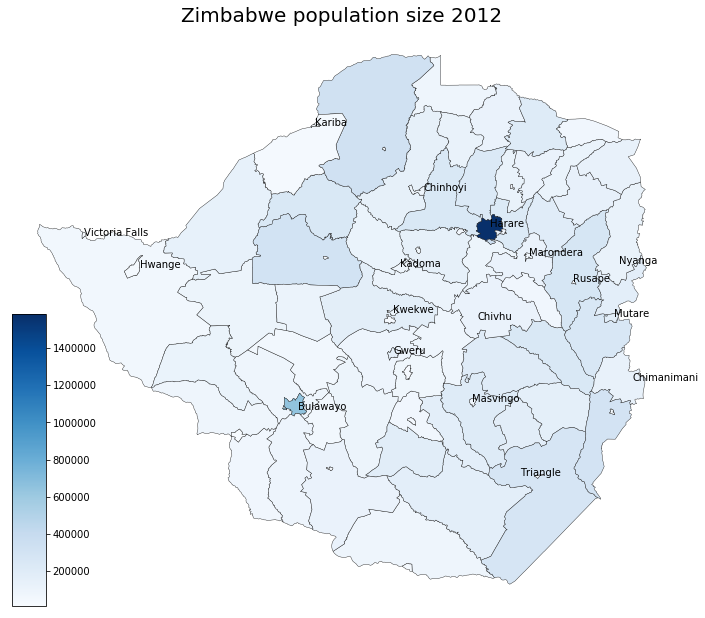

In [15]:
plot_gdf(dist, 'pop_2012', title='Zimbabwe population size 2012', towns=True, cmap='Blues', 
         legend=True, filename='images/zim_district_pop2012.png')

In [4]:
def bokeh_plot_map(geosource, data_col=None, columns=[], title='', palette='Blues', 
                   label='', plot_width=600):
    """Plot bokeh map from GeoJSONDataSource """

    palette = brewer[palette][8]
    palette = palette[::-1]
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette)#, low = 0, high = 100)

    color_bar = ColorBar(label_standoff=8,width = 500, height = 20,
                border_line_color=None,location = (0,0), orientation = 'horizontal')

    x = [(i, "@%s" %i) for i in columns]
    hover = HoverTool(
        tooltips=x, point_policy='follow_mouse')
    tools = ['wheel_zoom,pan,reset',hover]
    tile_provider = get_provider(Vendors.STAMEN_TERRAIN)
    p = figure(title = title, plot_width=plot_width, plot_height=int(plot_width*.9), toolbar_location = 'right', tools=tools)
    #p = figure(y_range=(-2411525,-1881111), x_range=(2799080,3722223),
    #           x_axis_type="mercator", y_axis_type="mercator", tools=tools)
    #p.add_tile(tile_provider)
    
    if data_col != None:
        color = {'field' :data_col , 'transform': color_mapper}
    else:
        color = 'gray'
    p.patches('xs','ys', source=geosource, line_width=0.8, line_color='black', fill_color=color, fill_alpha=1)
    #p.circle(x='xs',y='ys',size=5,fill_color='black',source=geosource)
    p.toolbar.logo = None
    #p.xaxis.visible = False
    #p.yaxis.visible = False    
    #Specify figure layout.
    #p.add_layout(color_bar, 'below')
    return p

## the provinces, districts and wards

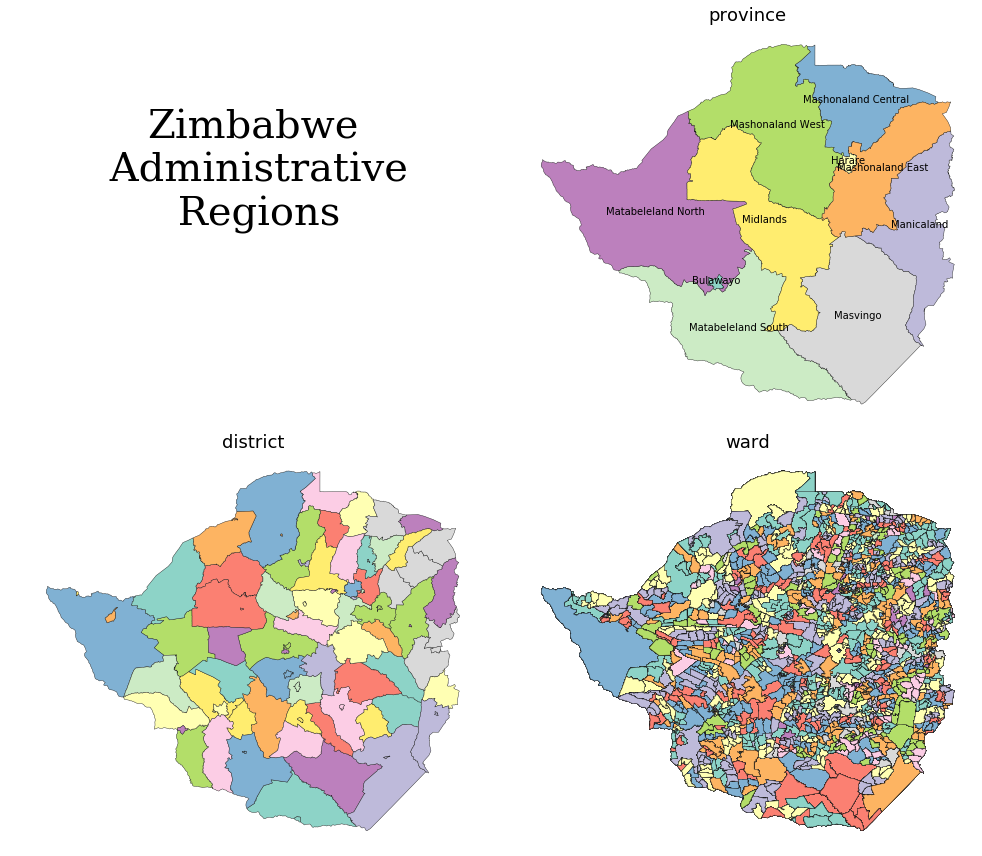

In [5]:
fig, ax = plt.subplots(2,2, figsize=(14,12))
axs=ax.flat
data = {'province':prov,'district':dist,'ward':ward}
i=1
font = {'family': 'serif',  
        'weight': 'normal',
        'size': 40,
        }
axs[0].axis('off')
axs[0].text(.5,.5,'Zimbabwe\n Administrative\n Regions',horizontalalignment='center', fontdict=font)
for d in data:
    ax=axs[i]
    data[d].plot(ax=ax, column=d,edgecolor='0.1',lw=0.4,cmap='Set3')
    if d == 'province':
        data[d].apply(lambda x: ax.annotate(s=x.province, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)
    ax.axis('off')
    ax.set_title(d,fontsize=18)
    i+=1    
plt.tight_layout()    
plt.savefig('images/zim_regions.png',dpi=200)
plt.savefig('images/zim_regions.svg')

## population 2012

In [ ]:
geosource = tools.get_geodatasource(dist)
p = bokeh_plot_map(geosource, data_col='pop_2012', columns=['district','pop_2012'], plot_width=800)
show(p)

In [ ]:
x=pd.concat([towns,dist])
geosource = tools.get_geodatasource(dist)
p = bokeh_plot_map(geosource, plot_width=600)
show(p)

## the grid

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
grid = gpd.read_file('data/Zimbabwe_grid.shp')
pp = gpd.read_file('data/ZWE_PowerPlants.shp')
prov.plot(ax=ax, color='white', edgecolor='0.1', lw=1)
grid.plot(edgecolor='blue',ax=ax, lw=1.5)
pp.plot(color='red',ax=ax, lw=1.5)
#print (pp)
pp.apply(lambda x: ax.annotate(s=x.PLANT, xy=x.geometry.centroid.coords[0], ha='left'),axis=1)
prov.apply(lambda x: ax.annotate(s=x.province, xy=x.geometry.centroid.coords[0], ha='center', c='gray'),axis=1)
ax.axis('off')
plt.title('Zimbabwe Electricity Grid',fontsize=16)
plt.tight_layout()   
plt.savefig('images/zim_grid.png',dpi=200)

## roads

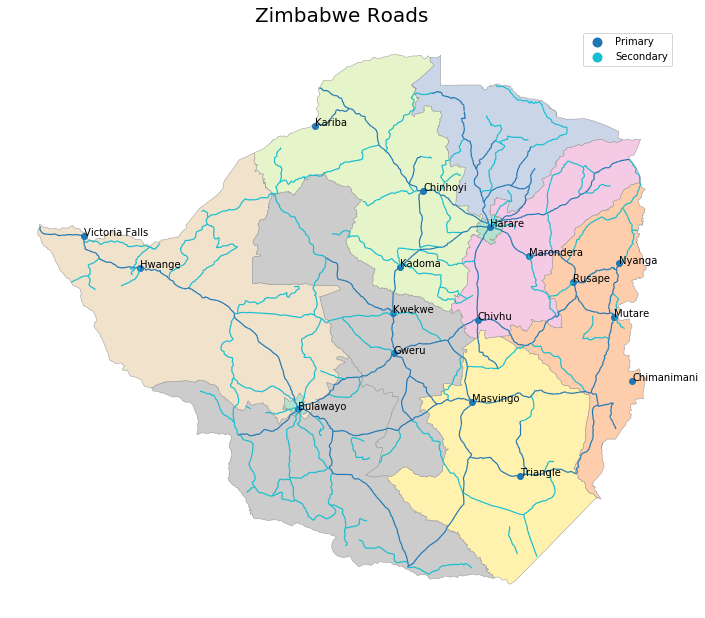

In [260]:
fig, ax = plt.subplots(1, figsize=(10,10))
roads = gpd.read_file('data/Zimbabwe_Roads.shp')

prov.plot(ax=ax, column='province',cmap='Pastel2', edgecolor='0.6', lw=.5)
maintowns.plot(ax=ax)
maintowns.apply(lambda x: ax.annotate(s=x.NAME, xy=x.geometry.centroid.coords[0], ha='left'),axis=1)
roads.plot(column='CLASS',categorical=True,ax=ax, lw=1.2, legend=True)
ax.axis('off')
plt.title('Zimbabwe Roads',fontsize=20)
plt.tight_layout()
plt.savefig('images/zim_roads.png',dpi=200)

## land classes in Rhodesia

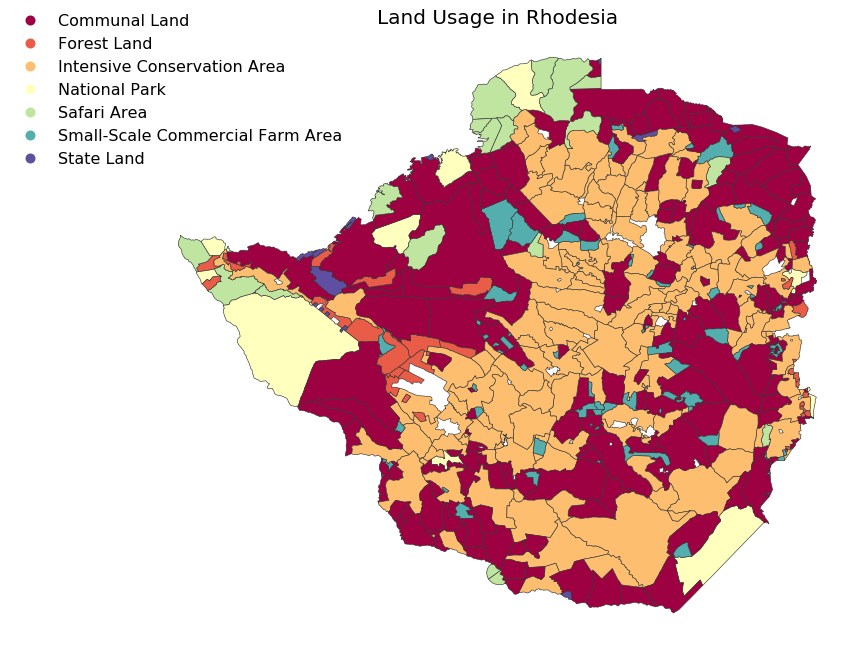

In [214]:
landuse = gpd.read_file('data/historic_land_classes.shp')
landuse = landuse.dropna()
fig, ax = plt.subplots(1, figsize=(12,10))
landuse.plot(column='class', categorical=True,cmap='Spectral',linewidth=.6, edgecolor='0.2', 
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title('Land Usage in Rhodesia',fontsize=20)
plt.tight_layout()
plt.savefig('images/rhodesia_land_classes.png',dpi=300)

In [ ]:
landuse['code'] = pd.Categorical(landuse['class']).codes
geosource = get_geodatasource(landuse)
p = bokeh_plot_map(geosource, data_col='code', columns=['Area_Name','class'], palette='Spectral', plot_width=800)
show(p)

## WB Spatial Database 2019

In [20]:
wb = gpd.read_file('data/zwe_adm3_2002.shp')
wb = wb.to_crs({'init': 'epsg:4326'}) 

In [27]:
sp_meta = pd.read_csv('data/zwe_adm3_metadata.csv')
#sp_meta[40:100]
wb.columns[100:150]

Index(['formal_ind', 'formal_a_1', 'informal_s', 'informal_a', 'informal_i',
       'informal_1', '___SERVICE', 'acc_elec_m', 'acc_elec_f', 'no_elec_m',
       'no_elec_f', 'acc_sant_m', 'acc_sant_f', 'no_sant_m', 'no_sant_f',
       'wat_impr_m', 'wat_impr_f', 'unwat_impr', 'unwat_im_1', '___EDUCATI',
       'm_pre_scho', 'm_primary_', 'm_secondar', 'm_tertiary', 'm_no_edu',
       'm_not_know', 'm_total', 'm_lte_pre_', 'm_lte_prim', 'm_gte_sec_',
       'm_gte_tert', 'm_no_edu_o', 'fem_pre_sc', 'fem_primar', 'fem_second',
       'fem_tertia', 'fem_no_edu', 'fem_not_kn', 'fem_total', 'fem_lte_pr',
       'fem_lte__1', 'fem_gte_se', 'fem_gte_te', 'fem_no_e_1', 'total_of_m',
       'total_of_1', 'total_of_2', 'total_of_3', 'total_of_4', 'total_of_5'],
      dtype='object')

In [ ]:
plot_gdf(wb, 'landclas_1', title='Zimbabwe land classes', legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False},
         categorical=True, legend=True, filename='images/zimbabwe_land_classes.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


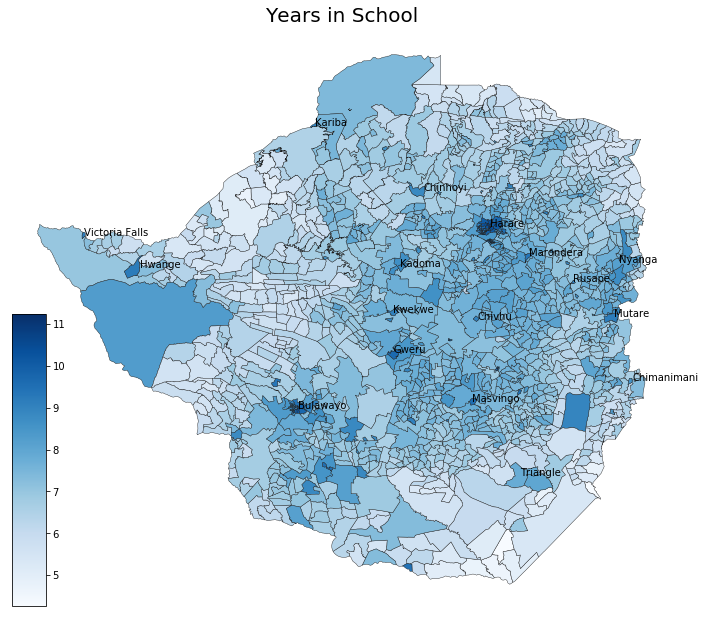

In [358]:
column='acc_elec_m'
gdf[column] = gdf[column].fillna(1)
wb['prop'] = wb[column]/wb['pop']
wb=wb.replace([np.inf, -np.inf], 0)
wb.sort_values('prop')
plot_gdf(wb, 'years_scho', title='Years in School', towns=True, cmap='Blues', legend=True, filename='images/zim_years_school.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


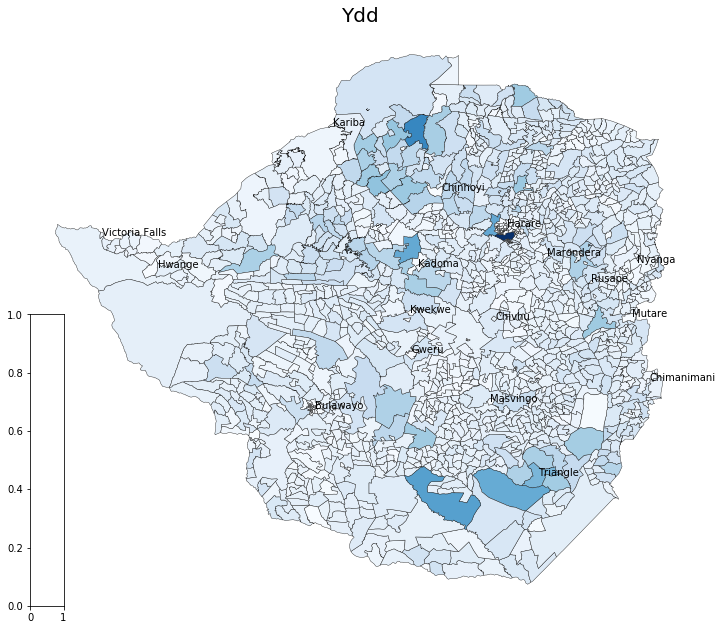

In [39]:
plot_gdf(wb, 'm_primary_', title='Ydd', towns=True, cmap='Blues', legend=True)#, filename='images/zim_years_school.png')

In [ ]:
#print (wb.columns[:40])
wb = gpd.read_file('data/zwe_adm3_2002.shp')
geosource = tools.get_geodatasource(wb)
p = bokeh_plot_map(geosource, data_col='pop', columns=['DISTRICT','LOCAL_AUTH','PROVINCE_1','pop','pop_m'], palette='Spectral', plot_width=600)
show(p)

In [ ]:
data_sel = Select(name='dataset', options=['test'])
cmap_sel = Select(name='cmap', value='Spectral', options=list(brewer.keys())) 

geosource = tools.get_geodatasource(landuse)
p = bokeh_plot_map(geosource, palette='RdYlGn', plot_width=600)

cmap_callback = CustomJS(args=dict(xr=p.x_range), code="""
    source.change.emit();
    """)

cmap_sel.js_on_change('value', cmap_callback) 
layout = row(p, column(data_sel,cmap_sel))
show(layout)

In [ ]:
tile_provider = get_provider(Vendors.CARTODBPOSITRON)
# range bounds supplied in web mercator coordinates
p = figure(y_range=(-2411000,-1881000), x_range=(2750000,3722000),
               x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)
show(p)

In [ ]:
output_file('plot.html')
show(p)